## Telechargement données avec IIIF (Gallica)

In [ ]:
import json
import csv
import time
import requests
from tqdm import tqdm
import os

### Récupération URL, image, filename, et annotations du manifest

In [ ]:
json_file_path = "/Users/nostradamus/Documents/encours/temporaire/cours_paleo_comput_enluminures/MiradorAnnotations/btv1b525064305/MiradorAnnotations_Enluminures.json"
with open(json_file_path, "r", encoding="utf-8-sig") as f:
    data = json.load(f)

manifest_key = next(iter(data))  
canvas_data = data[manifest_key]
manifest_name = manifest_key.split("/")[-2]

output_csv = "/Users/nostradamus/Documents/encours/temporaire/cours_paleo_comput_enluminures/MiradorAnnotations/annotations.csv"
fieldnames = ["Image_URL", "Annotations", "Saved_Filename"]
image_download_folder = f"/Users/nostradamus/Documents/encours/temporaire/cours_paleo_comput_enluminures/MiradorAnnotations/images/"

os.makedirs(image_download_folder, exist_ok=True)

image_counters = {}

with open(output_csv, "a", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for canvas_url, annotations in tqdm(canvas_data.items(), desc="Processing Canvases"):
        for annotation in annotations:
            on_url = annotation.get("on", "")
            if "#xywh=" in on_url:
                xywh_part = on_url.split("#xywh=")[-1]
            else:
                continue

            base_url_parts = canvas_url.split("canvas/")
            if len(base_url_parts) < 2:
                continue
            base_image_url = base_url_parts[0]
            page_number = base_url_parts[1]
            image_url = f"{base_image_url}{page_number}/{xywh_part}/pct:25/0/default.jpg"

            tags = [resource["chars"] for resource in annotation.get("resource", []) if resource.get("@type") == "oa:Tag"]
            annotation_text = ", ".join(tags)

            if page_number not in image_counters:
                image_counters[page_number] = 0
            image_counters[page_number] += 1

            image_filename = f"{manifest_name}_{page_number}_{image_counters[page_number]}.jpg"
            image_filepath = os.path.join(image_download_folder, image_filename)

            writer.writerow({"Image_URL": image_url, "Annotations": annotation_text, "Saved_Filename": image_filename})

            try:
                response = requests.get(image_url, stream=True)
                if response.status_code == 200:
                    with open(image_filepath, "wb") as img_file:
                        for chunk in response.iter_content(1024):
                            img_file.write(chunk)
                else:
                    print(f"Failed to download: {image_url}")
            except Exception as e:
                print(f"Error downloading {image_url}: {e}")

            time.sleep(6)

print(f"CSV file saved: {output_csv}")
print(f"Images downloaded to: {image_download_folder}")

## Classif non supervisée
### extraction de features avec VGG16 + clustering

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
import cv2

2025-02-13 11:57:44.911648: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 11:57:44.947998: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 11:57:45.195203: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 11:57:45.196347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 11:57:45.881859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [ ]:
def load_and_preprocess_images(folder_path, target_size=(224, 224)):
    model = VGG16(weights='imagenet', include_top=False)
    feature_list = []
    image_paths = []
    
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        features = model.predict(img_array).flatten()
        feature_list.append(features)
        image_paths.append(img_path)
        
    return np.array(feature_list), image_paths

def reduce_dimensionality(features, n_components=50):
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    return features_pca, pca

def cluster_images(features_pca, method='kmeans', n_clusters=5):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        model = DBSCAN(eps=5, min_samples=2)
    
    labels = model.fit_predict(features_pca)
    return labels

def visualize_clusters(image_paths, labels):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idxs = np.where(labels == label)[0]
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(idxs[:10]):
            img = cv2.imread(image_paths[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f'Cluster {label}')
        plt.show()

In [3]:
folder_path = "/home/cvidalgo/Documents/cours/PaleoComput/images"

In [4]:
features, image_paths = load_and_preprocess_images(folder_path)

1/1 [==============================] - 0s 156ms/step


In [5]:
features_pca, pca = reduce_dimensionality(features)

In [6]:
labels = cluster_images(features_pca, method='kmeans', n_clusters=5)

/home/cvidalgo/miniconda3/envs/research/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


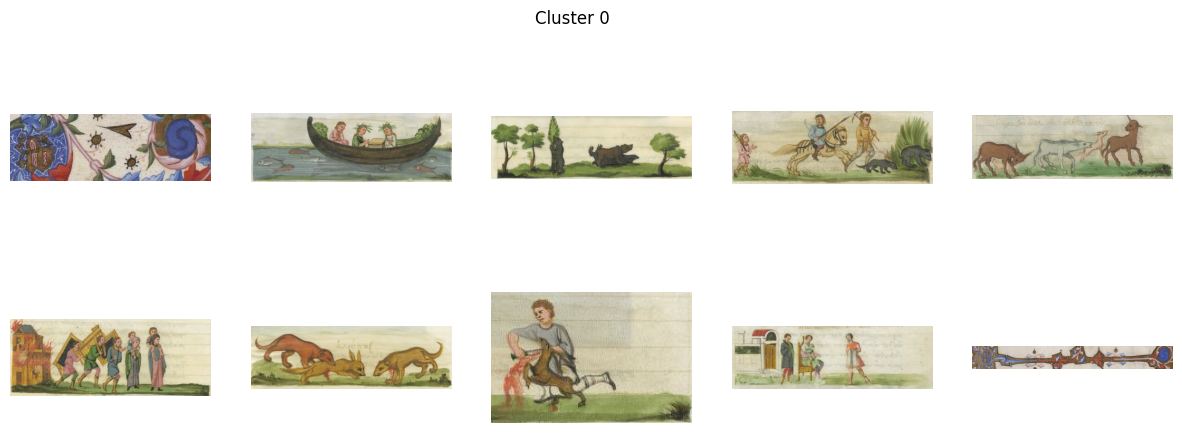

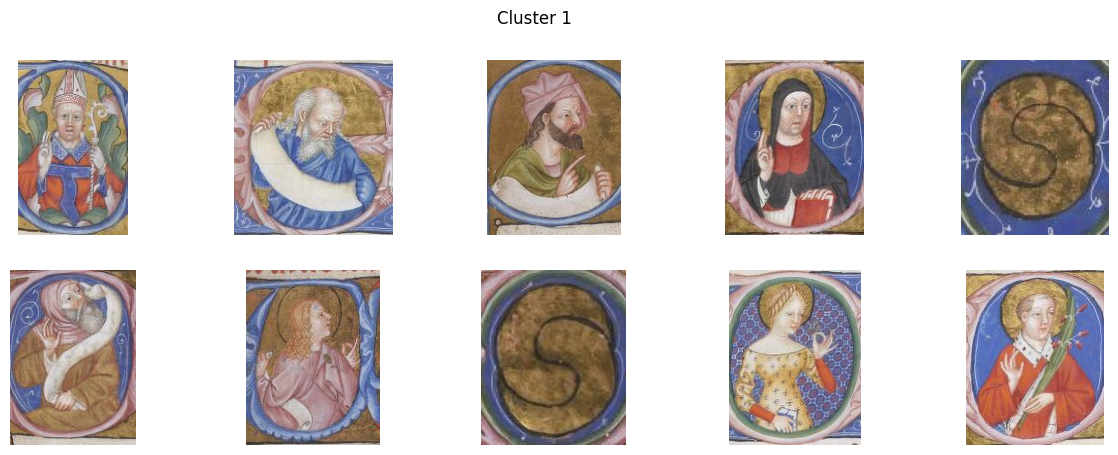

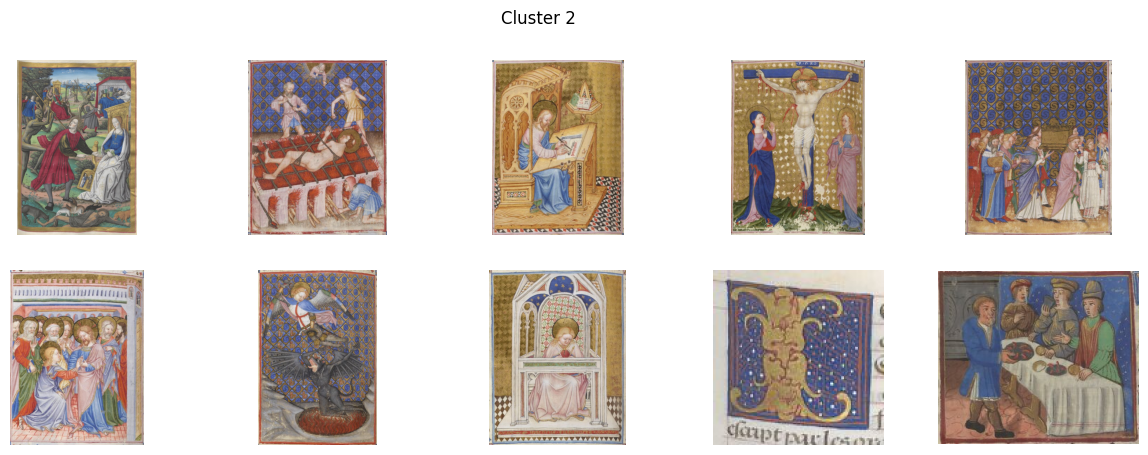

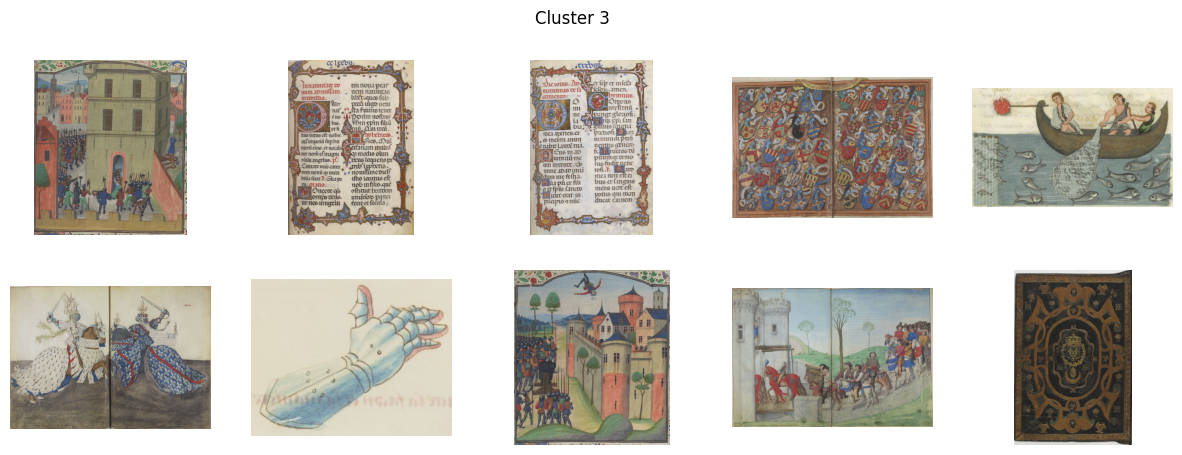

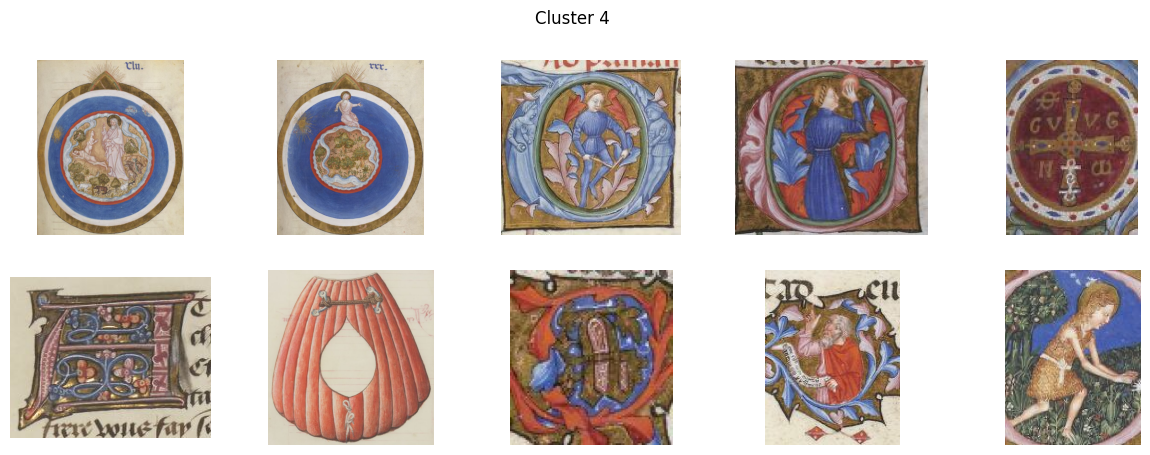

In [7]:
visualize_clusters(image_paths, labels)

In [9]:
labels = cluster_images(features_pca, method='dbscan', n_clusters=5)

In [ ]:
visualize_clusters(image_paths, labels)

### Visualisation feature map

In [8]:

def display_feature_map(image_path, target_size=(224, 224)):
    model = VGG16(weights='imagenet', include_top=False)
    
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    features = model.predict(img_array)
    heatmap = np.mean(features[0], axis=-1)
    heatmap = cv2.resize(heatmap, (target_size[1], target_size[0]))
    heatmap = np.uint8(255 * heatmap / np.max(heatmap))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Feature Activation Map")
    plt.show()

1/1 [==============================] - 0s 135ms/step


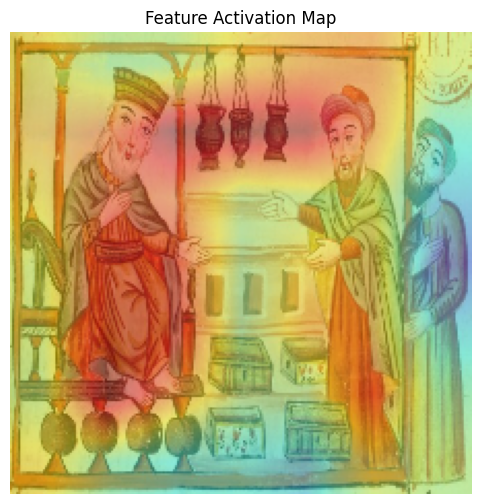

In [9]:
display_feature_map('/home/cvidalgo/Documents/cours/PaleoComput/images/btv1b8419219x_f60_1.jpg')

1/1 [==============================] - 0s 135ms/step


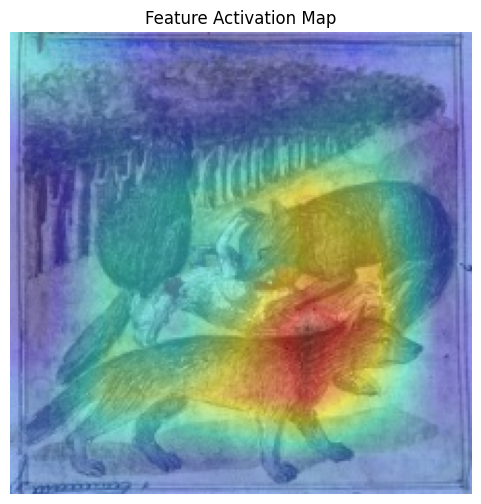

In [10]:
display_feature_map('/home/cvidalgo/Documents/cours/PaleoComput/images/btv1b525064305_f50_1.jpg')

1/1 [==============================] - 0s 127ms/step


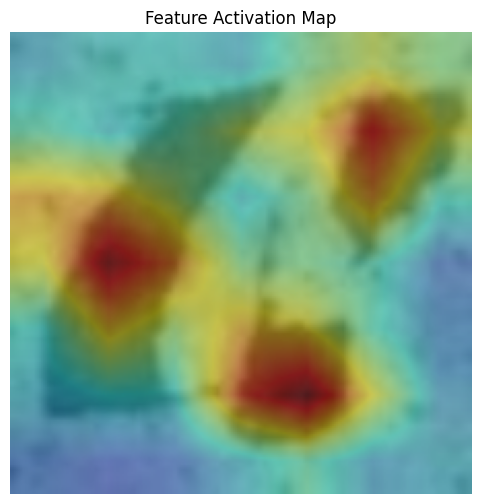

In [11]:
display_feature_map('/home/cvidalgo/Documents/cours/2024-04-05/data/images/1_1_1_8585.jpg')

In [ ]:
display_feature_map('/home/cvidalgo/Documents/cours/2024-04-05/data/images/1_1_2_8391.jpg')

## Classification supervisée avec YOLO Classify

In [20]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
def split_images_into_folders(csv_path, image_folder, output_folder, test_size=0.2):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    
    df['class'] = df['Annotations'].str.split(',').str[0]
    df = df[['Saved_Filename', 'class']]
    df.rename(columns={'Saved_Filename': 'filename'}, inplace=True)
    
    df = df.dropna(subset=['class'])
    class_counts = df['class'].value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    df = df[df['class'].isin(valid_classes)]
    
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['class'], random_state=42)
    
    def copy_images(df_subset, subset_name):
        for _, row in df_subset.iterrows():
            src_path = os.path.join(image_folder, row['filename'])
            dest_dir = os.path.join(output_folder, subset_name, row['class'])
            dest_path = os.path.join(dest_dir, row['filename'])
            os.makedirs(dest_dir, exist_ok=True)
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)
    
    copy_images(train_df, "train")
    copy_images(val_df, "val")
    
    return train_df, val_df

In [ ]:
csv_path = "/home/chahan/PaleoComput/annotations.csv"
image_folder = "/home/chahan/PaleoComput/images"
output_folder = "dataset"
train_df, val_df = split_images_into_folders(csv_path, image_folder, output_folder)


In [ ]:

def ensure_class_balance(train_folder, val_folder):
    train_classes = set(os.listdir(train_folder))
    val_classes = set(os.listdir(val_folder))
    
    common_classes = train_classes.intersection(val_classes)
    
    for class_name in train_classes - common_classes:
        shutil.rmtree(os.path.join(train_folder, class_name), ignore_errors=True)
    for class_name in val_classes - common_classes:
        shutil.rmtree(os.path.join(val_folder, class_name), ignore_errors=True)
    
    print("Ensured class balance between train and val folders.")

In [ ]:
ensure_class_balance(os.path.join(output_folder, "train"), os.path.join(output_folder, "val"))

In [ ]:
from ultralytics import YOLO

In [ ]:
mon_modele = YOLO('yolo11n-cls.pt')

In [ ]:
training = mon_modele.train(data = '/home/cvidalgo/Documents/cours/PaleoComput/dataset/')

In [16]:
classify_model = YOLO('/home/cvidalgo/Documents/cours/PaleoComput/runs/classify/train/weights/best.pt')

In [ ]:
classify_model.predict('/home/cvidalgo/Documents/cours/PaleoComput/images/btv1b8419219x_f60_1.jpg', visualize=True)

### Comparaison avec SAM2 (YOLO)

In [1]:
from ultralytics import SAM

In [2]:
model = SAM("sam2.1_b.pt")

In [3]:
results = model.predict('/home/cvidalgo/Documents/cours/PaleoComput/images/btv1b8419219x_f60_1.jpg', save=True)


image 1/1 /home/cvidalgo/Documents/cours/PaleoComput/images/btv1b8419219x_f60_1.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 160564.1ms
Speed: 16.8ms preprocess, 160564.1ms inference, 14.8ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict2


## Non supervisé / comparaison des embeddings

In [1]:
import faiss
import os
import numpy as np
import pandas as pd
import torch

from PIL import Image
from tqdm import tqdm
from transformers import AutoImageProcessor, EfficientNetModel, ViTModel, AutoModel, CLIPProcessor, CLIPModel, Blip2Processor, Blip2Model

from transformers import Pipeline
from transformers.image_utils import load_image

/Users/nostradamus/miniconda3/envs/spacy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt

In [5]:
dataset_dir = '/Users/nostradamus/Downloads/data/'
test_image = Image.open(os.path.join(dataset_dir, '01f961b7-06460_bbox0.jpg'))
print(test_image.size)

(325, 456)


In [ ]:
## EfficientNet feature extraction
image_processor = AutoImageProcessor.from_pretrained("google/efficientnet-b7", use_fast=False)
model = EfficientNetModel.from_pretrained("google/efficientnet-b7")
inputs = image_processor(test_image, return_tensors='pt')
print('input shape: ', inputs['pixel_values'].shape)

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    
embedding = outputs.hidden_states[-1]
print('embedding shape: ', embedding.shape)

embedding = torch.mean(embedding, dim=[2,3])
print('after reducing: ', embedding.shape)

input shape:  torch.Size([1, 3, 600, 600])
embedding shape:  torch.Size([1, 640, 19, 19])
after reducing:  torch.Size([1, 640])


: 

In [17]:
## ViT feature extraction
image_processor = AutoImageProcessor.from_pretrained("google/vit-large-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-large-patch16-224-in21k")
inputs = image_processor(test_image, return_tensors='pt')
print('input shape: ', inputs['pixel_values'].shape)

with torch.no_grad():
    outputs = model(**inputs)
    
embedding = outputs.last_hidden_state
embedding = embedding[:, 0, :].squeeze(1)
print('embedding shape: ', embedding.shape)

input shape:  torch.Size([1, 3, 224, 224])
embedding shape:  torch.Size([1, 1024])


In [18]:
## DINO-v2 feature extraction
image_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
inputs = image_processor(images=test_image, return_tensors='pt')
print('input shape: ', inputs['pixel_values'].shape)

with torch.no_grad():
    outputs = model(**inputs)
    
embedding = outputs.last_hidden_state
embedding = embedding[:, 0, :].squeeze(1)
print('embedding shape: ', embedding.shape)

input shape:  torch.Size([1, 3, 224, 224])
embedding shape:  torch.Size([1, 768])


In [19]:
## CLIP feature extraction
image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
inputs = image_processor(images=test_image, return_tensors='pt', padding=True)
print('input shape: ', inputs['pixel_values'].shape)

with torch.no_grad():
    outputs = model.get_image_features(**inputs)
    
print('embedding shape: ', outputs.shape)

input shape:  torch.Size([1, 3, 224, 224])
embedding shape:  torch.Size([1, 512])


In [20]:
# ## BLIP-2 feature extraction
# image_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
# # prepare input image
# inputs = image_processor(images=test_image, return_tensors='pt', padding=True)
# print('input shape: ', inputs['pixel_values'].shape)

# with torch.no_grad():
#     outputs = model.get_qformer_features(**inputs)
#     outputs = outputs.last_hidden_state
    
# embedding = torch.mean(outputs, dim=1).squeeze(1)
# print('after reducing: ', embedding.shape)

In [30]:
## Image similarity search
### custom pipeline for EfficientNet
class EfficientNetPipeline(Pipeline):
    
    def _sanitize_parameters(self, **kwargs):
        return {}, {}, {}

    def preprocess(self, image):
        image = load_image(image)
        model_inputs = self.image_processor(images=image, return_tensors="pt")
        
        return model_inputs

    def _forward(self, model_inputs):
        with torch.no_grad():
            outputs = self.model(**model_inputs, output_hidden_states=True)
        
        return outputs

    def postprocess(self, model_outputs):
        embedding = model_outputs.hidden_states[-1]
        embedding = torch.mean(embedding, dim=[2,3])
        
        return embedding
### custom pipeline for ViT

class ViTPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        return {}, {}, {}

    def preprocess(self, image):
        image = load_image(image)
        model_inputs = self.image_processor(images=image, return_tensors="pt")
        return model_inputs

    def _forward(self, model_inputs):
        with torch.no_grad():
            outputs = self.model(**model_inputs)
        
        return outputs

    def postprocess(self, model_outputs):
        embedding = model_outputs.last_hidden_state
        embedding = embedding[:, 0, :].squeeze(1)
        
        return embedding
    
### custom pipeline for DINO-v2

class DINOv2Pipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        return {}, {}, {}

    def preprocess(self, image):
        image = load_image(image)
        model_inputs = self.image_processor(images=image, return_tensors="pt")
        
        return model_inputs

    def _forward(self, model_inputs):
        with torch.no_grad():
            outputs = self.model(**model_inputs)
        
        return outputs

    def postprocess(self, model_outputs):
        embedding = model_outputs.last_hidden_state
        embedding = embedding[:, 0, :].squeeze(1)
        
        return embedding
    
### custom pipeline for CLIP
class CLIPPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        return {}, {}, {}

    def preprocess(self, image):
        image = load_image(image)
        model_inputs = self.image_processor(images=image, return_tensors="pt")
        
        return model_inputs

    def _forward(self, model_inputs):
        with torch.no_grad():
            outputs = self.model.get_image_features(**model_inputs)
        
        return outputs

    def postprocess(self, model_outputs):
        
        return model_outputs
    
### custom pipeline for BLIP2
class BLIP2Pipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        return {}, {}, {}

    def preprocess(self, image):
        image = load_image(image)
        model_inputs = self.image_processor(images=image, return_tensors="pt")
        
        return model_inputs

    def _forward(self, model_inputs):
        with torch.no_grad():
            outputs = self.model.get_qformer_features(**model_inputs)
        
        return outputs

    def postprocess(self, model_outputs):
        embedding = model_outputs.last_hidden_state
        embedding = torch.mean(embedding, dim=1).squeeze(1)
        
        return embedding
    
def define_model(model_name: str):
    if model_name == 'EfficientNet':
        image_processor = AutoImageProcessor.from_pretrained("google/efficientnet-b7")
        model = EfficientNetModel.from_pretrained("google/efficientnet-b7")
    elif model_name == 'ViT':
        image_processor = AutoImageProcessor.from_pretrained("google/vit-large-patch16-224-in21k")
        model = ViTModel.from_pretrained("google/vit-large-patch16-224-in21k")
    elif model_name == 'DINO-v2':
        image_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        model = AutoModel.from_pretrained('facebook/dinov2-base')
    elif model_name == 'CLIP':
        image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    elif model_name == 'BLIP2':
        image_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
        model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
        
    return image_processor, model

def load_pipeline(model_name: str):
    image_processor, model = define_model(model_name=model_name)
    
    if model_name == 'EfficientNet':
        pipeline = EfficientNetPipeline(model=model, image_processor=image_processor, device=0)
    elif model_name == 'ViT':
        pipeline = ViTPipeline(model=model, image_processor=image_processor, device=0)
    elif model_name == 'DINO-v2':
        pipeline = DINOv2Pipeline(model=model, image_processor=image_processor, device=0)
    elif model_name == 'CLIP':
        pipeline = CLIPPipeline(model=model, image_processor=image_processor, device=0)
    elif model_name == 'BLIP2':
        pipeline = BLIP2Pipeline(model=model, image_processor=image_processor, device=0)
        
    return pipeline

def register_embeddings(embeddings):
    vector_dim = embeddings.shape[1]
    
    index = faiss.IndexFlatIP(vector_dim)
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    
    return index

In [31]:
def image_similarity_search(embeddings, index, image_name_list, model_name, result_dir, top_k=6):
    
    result_dict = {
        'top0_similar': [],
        'top1_similar': [],
        'top2_similar': [],
        'top3_similar': [],
        'top4_similar': [],
        'top5_similar': []
    }
    
    for embed in embeddings:
        embed = embed.reshape(1, -1)
        faiss.normalize_L2(embed)
        distances, ann = index.search(embed, k=top_k)

        for k in range(top_k):
            idx = ann[0][k]
            
            result_dict[f'top{str(k)}_similar'].append(image_name_list[idx])

    df = pd.DataFrame.from_dict(result_dict)
    df.to_csv(os.path.join(result_dir, f'{model_name}.csv'), index=None)

def collect_data(dataset_dir):
    files_list = []

    for root, _, files in os.walk(dataset_dir):
        if len(files) > 0:
            for f in files:
                if 'jpg' in f:
                    
                    filepath = os.path.join(root, f)
                    files_list.append(filepath)

    return files_list


In [32]:
model_name = 'CLIP'
batch_size = 1

dataset_dir = '/home/chahan/PaleoComput/images/'
result_dir = './results_test'
os.makedirs(result_dir, exist_ok=True)

pipeline = load_pipeline(model_name=model_name)


dataset = collect_data(dataset_dir=dataset_dir)

if os.path.exists(os.path.join(result_dir, f'{model_name}.npy')):
    embeddings = np.load(os.path.join(result_dir, f'{model_name}.npy'))
    print('embedding shape: ', embeddings.shape)
else:
    
    embeddings = []
    
    for idx in tqdm(range(0, len(dataset), batch_size)):
        
        data = dataset[idx: idx + batch_size]
        
        out = pipeline(data, batch_size=batch_size)
        embeddings += [embed.detach().cpu() for embed in out]
        
        del out
        torch.cuda.empty_cache()

    embeddings = torch.cat(embeddings, dim=0).detach().cpu().numpy()
    print('embedding shape: ', embeddings.shape)
    np.save(os.path.join(result_dir, f'{model_name}.npy'), embeddings)

embedding shape:  (631, 512)


In [38]:

embeddings = embeddings.astype(np.float32)
index = register_embeddings(embeddings)
image_similarity_search(embeddings=embeddings, index=index, image_name_list=dataset, model_name=model_name, result_dir=result_dir)


file_paths = {
    # "CLIP": "/home/chahan/PaleoComput/results_test/CLIP.csv",
    # "DINO-v2": "/home/chahan/PaleoComput/results_test/DINO-v2.csv",
    "EfficientNet": "/home/chahan/PaleoComput/results_test/EfficientNet.csv",
    # "ViT": "/home/chahan/PaleoComput/results_test/ViT.csv",
    "BLIP2": "/home/chahan/PaleoComput/results_test/BLIP2.csv"
}

dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

for name, df in dfs.items():
    df.columns = [f"{col}_{name}" if col != "top0_similar" else col for col in df.columns]

merged_df = dfs["BLIP2"]
for name in ["EfficientNet", "BLIP2"]:
    merged_df = merged_df.merge(dfs[name], on="top0_similar", how="inner")

df_sample = merged_df.head(5)

def show_comparison(row_index):
    """Displays a row with one technology, showing top0 and its 5 matches."""
    
    if row_index >= len(merged_df):
        print(f"Row {row_index} is out of range.")
        return

    row = merged_df.iloc[row_index]


    for model in ["ViT", "BLIP2"]:
    
        col_names = [f"top{i}_similar_{model}" for i in range(6)] 
        image_paths = [row[col] for col in col_names if col in row]

    
        valid_entries = [(img, col_names[i]) for i, img in enumerate(image_paths) if os.path.exists(img)]

        if not valid_entries:
            print(f"No valid images found for {model} in row {row_index}. Skipping...")
            continue

        valid_paths, valid_labels = zip(*valid_entries)

    
        fig, axes = plt.subplots(1, len(valid_paths), figsize=(3 * len(valid_paths), 3))
        fig.suptitle(f"{model} - Row {row_index}", fontsize=14)

        for i, (img_path, lbl) in enumerate(valid_entries):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(lbl.replace(f"_similar_{model}", ""), fontsize=10)
            axes[i].axis("off")

        plt.show()

In [39]:
df_sample = merged_df.head(5)

In [40]:
df_sample

top0_similar  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b60005116_...   

                                top1_similar_BLIP2_x  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b60005116_...   

                                top2_similar_BLIP2_x  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b8470209d_...   

                                top3_similar_BLIP2_x  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b60005116_...   

                                top4_similar_BLIP2_x  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b60005116_...   

                                top5_similar_BLIP2_x  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b60005116_...   

                           top1_similar_EfficientNet  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b10523282n...   

                           top2_similar_EfficientNet  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b525064305...   

                           top3_similar_EfficientNet  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b60005116_...   

                           top4_similar_EfficientNet  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b525064305...   

                           top5_similar_EfficientNet  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b10523282n...   

                                top1_similar_BLIP2_y  \
0  /home/chahan/PaleoComput/images/btv1b60005116_...   
1  /home/chahan/PaleoComput/images/btv1b60005116_...   
2  /home/chahan/PaleoComput/images/btv1b8419219x_...   
3  /home/chahan/PaleoComput/images/btv1b8470209d_...   
4  /home/chahan/PaleoComput/images/btv1b60005116_... 

In [46]:
def show_comparison(row_index):
    
    if row_index >= len(merged_df):
        print(f"Row {row_index} is out of range.")
        return

    row = merged_df.iloc[row_index]

    for model in ["CLIP", "DINO-v2", "EfficientNet", "ViT", "BLIP2"]:
    
        col_names = [f"top{i}_similar_{model}" for i in range(6)] 
        image_paths = [row[col] for col in col_names if col in row]    
        valid_entries = [(img, col_names[i]) for i, img in enumerate(image_paths) if os.path.exists(img)]

        if not valid_entries:
            print(f"No valid images found for {model} in row {row_index}. Skipping...")
            continue

        valid_paths, valid_labels = zip(*valid_entries)
    
        fig, axes = plt.subplots(1, len(valid_paths), figsize=(3 * len(valid_paths), 3))
        fig.suptitle(f"{model} - Row {row_index}", fontsize=14)

        for i, (img_path, lbl) in enumerate(valid_entries):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(lbl.replace(f"_similar_{model}", ""), fontsize=10)
            axes[i].axis("off")

        plt.show()

No valid images found for CLIP in row 16. Skipping...
No valid images found for DINO-v2 in row 16. Skipping...


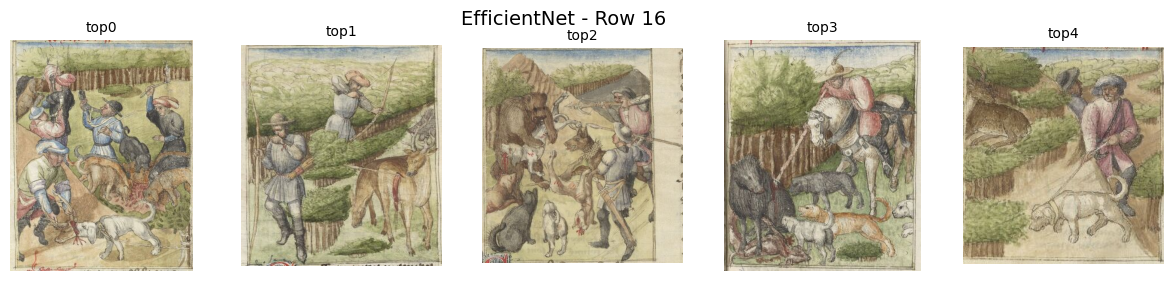

No valid images found for ViT in row 16. Skipping...
No valid images found for BLIP2 in row 16. Skipping...


In [47]:
show_comparison(16)